# Assessing Satellite Albedo Data Resolution for Urban Heat Island Mitigation Strategies

## 🌍 Use case: Effect of mitigation strategies on urban heat islands (UHI) in Bangalore, India

## ❓ Quality assessment question
**Can changes in vegetation used as a mitigation approach for urban heat islands (UHI) be adequately observed using surface albedo datasets?**

Urban heat islands (UHIs) are metropolitan areas that are significantly warmer than the surrounding rural areas. The formation of UHI is driven by many factors, such as the loss of trees, the thermal properties of building materials, anthropogenic heat generation, air pollution (aerosols and trace gases), etc. The most common and severe impact of UHI is on the health of people. Despite the challenge of properly assessing and mitigating their effects, heat waves in this area likely lead people to suffer from heat strokes, fainting, and even death sometimes. Hence, it is important to study UHI for the formulation and implementation of better environmental and health policies. In the following analysis, we focus on Indian cities that, over the past few decades, have largely expanded; among these are Delhi, Mumbai, Bangalore, etc. We specifically focus on the city of Bangalore to verify the progress made towards the mitigation of the UHI and enhancing the local greenery using the values of surface albedo. The presented analysis evaluates the efficacy of the spatial resolution of the albedo dataset in quantifying the influence of greenery and other mitigation strategies. It concludes that changes in vegetation used as a mitigation approach for urban heat islands (UHI) can be adequately observed using surface albedo datasets.

## 📢 Quality assessment statement

• The spatial maps of albedo in the city of Bangalore for the years 1999–2000 and 2014–2015 reveal that the spatial resolution of the CDS surface albedo 10-daily gridded dataset is sufficient to quantify and monitor the effect of greenery and other mitigation strategies on UHI.

• This study demonstrates that the CDS surface albedo dataset can be used to investigate the effects of urban areas, greenery, and open fields in support of the study of the UHI effect.

## 📋 Methodology
This notebook provides an analysis of surface albedo data to assess the UHI effect and the impact of greenery and other mitigation strategies. The analysis involves several key steps:
1. Download surface albedo data (SPOT-VGT v2 (time period 1999–2000) and PROBA-VGT v2 (time period 2014–2015)). (ALBB_BH (broadband hemispherical albedo over total spectrum); horizontal resolution: ~1 km; temporal resolution: 10 days)
2. Create a raster plot of albedo.
3. Plot seasonal maps of Albedo.

## 📈 Analysis and results

(section-1)=
### 1. Download surface albedo data
We used standard libraries (xarray, matplotlib.dates, matplotlib.colors, matplotlib.pyplot) for this notebook. First, we defined the parameters and transformed the data, and finally the data was downloaded for albedo.

In [5]:
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, plot, utils

plt.style.use("seaborn-v0_8-notebook")
# Region
area = [15, 75, 10, 80]

# Zoom
lon_slice = slice(77.4, 77.8)
lat_slice = slice(12.8, 13.2)

# Periods
satelite_years = {"spot": ["1999", "2000"], "proba": ["2014", "2015"]}

collection_id_albedo = "satellite-albedo"
albedo_request = {
    "format": "zip",
    "variable": "albb_bh",
    "sensor": "vgt",
    "product_version": "v2",
    "horizontal_resolution": "1km",
    "month": [f"{month:02d}" for month in range(1, 13)],
    "nominal_day": "10",
    "area": area,
}

def regionalised_func(ds, lon_slice, lat_slice, func):
    ds = utils.regionalise(ds, lon_slice=lon_slice, lat_slice=lat_slice)
    return func(ds)

albedo_kwargs = {
    "chunks": {"year": 1, "month": 1},
    "drop_variables": ["crs"],
}

# First Dataset
datasets = []
for satellite, years in satelite_years.items():
    ds = download.download_and_transform(
        collection_id_albedo,
        albedo_request | {"satellite": satellite, "year": years},
        transform_func=diagnostics.time_weighted_mean,
        transform_chunks=False,
        **albedo_kwargs,
    )
    datasets.append(ds.expand_dims(satellite=[satellite]))
ds_albedo_maps = xr.concat(datasets, "satellite")

# Second Dataset
datasets = []
for satellite, years in satelite_years.items():
    ds = download.download_and_transform(
        collection_id_albedo,
        albedo_request | {"satellite": satellite, "year": years},
        transform_func=diagnostics.seasonal_weighted_mean,
        transform_chunks=False,
        **albedo_kwargs,
    )
    datasets.append(ds.expand_dims(satellite=[satellite]))  # Fix indentation here
ds_albedo_season_maps = xr.concat(datasets, "satellite")

# Time Series for Zoomed Region
albedo_timeseries_zoom = {}
for satellite, years in satelite_years.items():
    albedo_timeseries_zoom[satellite] = download.download_and_transform(
        collection_id_albedo,
        albedo_request | {"satellite": satellite, "year": years},
        transform_func=regionalised_func,
        transform_func_kwargs={
            "lon_slice": lon_slice,  "lat_slice": lat_slice,
            "func": diagnostics.spatial_weighted_mean,
        },
        **albedo_kwargs,
    )


100%|██████████| 24/24 [00:01<00:00, 15.91it/s]


(section-2)=
### 2. Create a raster plot of albedo.
First the plotting functions were defined, and then the time-weighted raster plot of albedo was plotted.

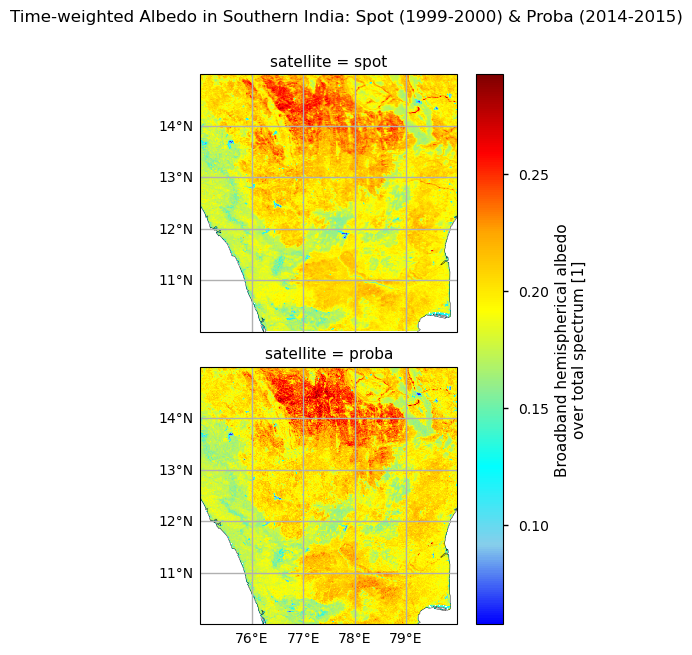

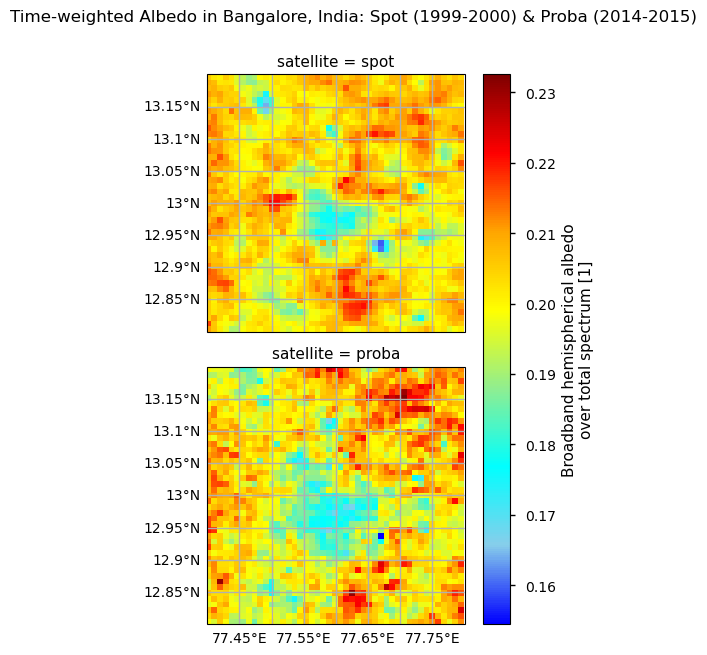

In [6]:
def plot_maps(da, lon_slice=None, lat_slice=None, area=area, title="", **kwargs):
    if lon_slice is None:
        lon_slice = slice(*sorted([area[1], area[3]]))
    if lat_slice is None:
        lat_slice = slice(*sorted([area[0], area[2]]))

    kwargs.setdefault("row", "satellite" if "satellite" in da.dims else None)
    kwargs.setdefault("col", "season" if "season" in da.dims else None)
    da["longitude"] = da["longitude"].astype("float32")
    da["latitude"] = da["latitude"].astype("float32")
    da = utils.regionalise(da, lon_slice=lon_slice, lat_slice=lat_slice)

    facet = plot.projected_map(da, **kwargs)
    for ax in facet.axs.flatten():
        ax.set_extent(
            [lon_slice.start, lon_slice.stop, lat_slice.start, lat_slice.stop]
        )
       
    return facet

custom_cmap_s = mcolors.LinearSegmentedColormap.from_list(
    "CustomColorMap",
    ["blue", "skyblue", "cyan", "lightgreen", "yellow", "orange", "red", "maroon"],
)

facet_albedo = plot_maps(
   ds_albedo_maps["AL_BH_BB"], 
    cmap=custom_cmap_s
  # title="Satellite: Spot"

)

plt.suptitle("Time-weighted Albedo in Southern India: Spot (1999-2000) & Proba (2014-2015)", fontsize=12, y=1.05)
plt.show()
facet_albedo_zoom = plot_maps(
    ds_albedo_maps["AL_BH_BB"],
    lon_slice=lon_slice,
    lat_slice=lat_slice,
    cmap=custom_cmap_s
   
)
plt.suptitle("Time-weighted Albedo in Bangalore, India: Spot (1999-2000) & Proba (2014-2015)", fontsize=12, y=1.05)
plt.show()

(section-3)=
### Plot seasonal maps of albedo

Text(0.5, 1.05, 'Seasonal Albedo Maps for Bangalore: Spot (1999-2000) & Proba (2014-2015)')

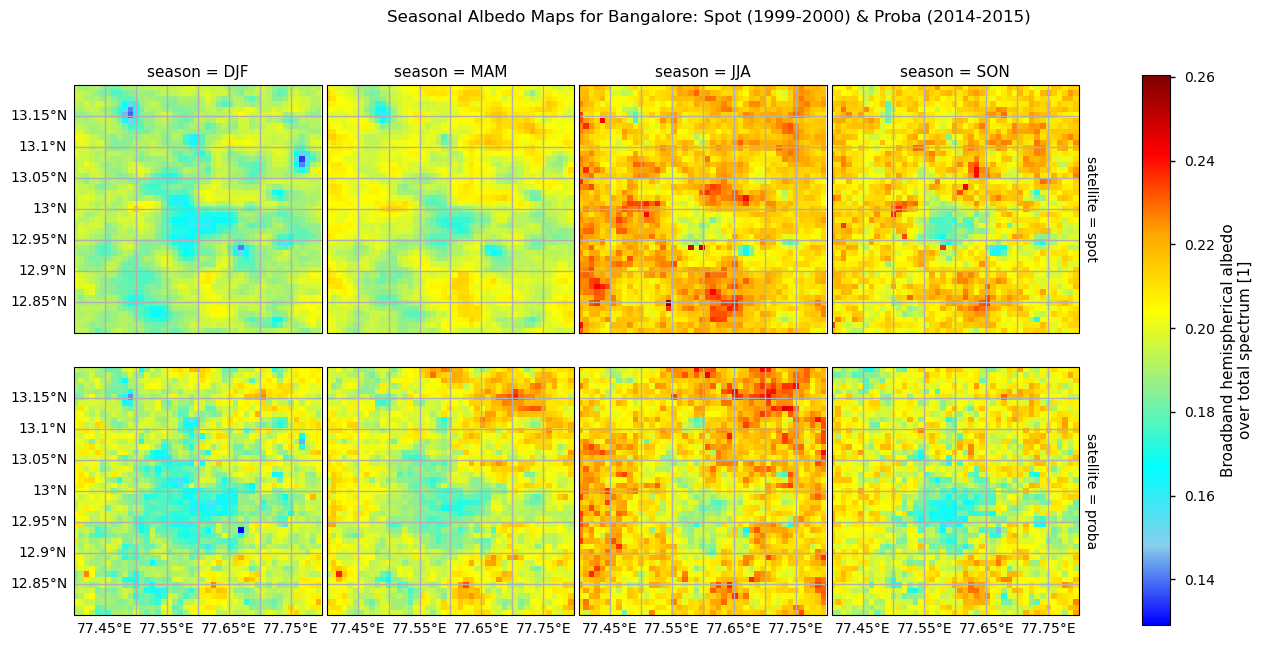

In [9]:
# Define the desired order of seasons
desired_order = ["DJF", "MAM", "JJA", "SON"]

# Reorder the seasons based on the desired order
reordered_data_albedo = ds_albedo_season_maps["AL_BH_BB"].sel(season=desired_order)

# Plot the maps using the reordered data
facet_albedo_zoom = plot_maps(
    reordered_data_albedo,
    lon_slice=lon_slice,
    lat_slice=lat_slice,
    cmap=custom_cmap_s,
)

facet_albedo_zoom.fig.suptitle("Seasonal Albedo Maps for Bangalore: Spot (1999-2000) & Proba (2014-2015)", fontsize=12, y=1.05)

### Results

• The spatial resolution of the CDS surface albedo 10-daily gridded dataset is sufficient to monitor if the enhancement of greenery, as a mitigation strategy for the Urban Heat Island (UHI) effects, has actually occurred in urban areas. 

• The seasonal albedo maps for 1999–2000 and 2014–2015 reveal lower albedo values in the city center compared to the surrounding areas. According to Google Maps, the city center is dominated by built-up areas interspersed with some green spaces, while the outskirts are predominantly agricultural land (vegetation) with some open fields and infrastructural development areas. Moreover, over the two time periods, an increase in the area with lower albedo values is observed in the city center. This finding aligns with the research by Kanga et al. (2022), Ramachandra and Aithal (2019), and TERI (2017), which report that the city center is heavily built-up while the outskirts are covered with vegetation. These studies also document a significant increase in built-up areas and a decline in vegetation cover in each subsequent decade since 1973.

• Despite the increase in some areas of the albedo values, compatible with a greenery enhancement, the relatively low albedo values (< 0.24) observed in the outskirts suggest that these areas are largely open fields with no vegetation cover, indicating their potential for future urbanization. 

• An increase in albedo across the city and suburbs during the monsoon season (JJA), due to the natural enhancement of the greenery in a humid season, suggests that the CDS surface albedo dataset effectively captures the spatial variation of albedo across different seasons.

## ℹ️ If you want to know more
### References

1. Kanga, S., Meraj, G., Johnson, B. A., Singh, S. K., PV, M. N., Farooq, M., ... & Sahu, N. (2022). Understanding the Linkage between Urban Growth and Land Surface Temperature — A Case Study of Bangalore City, India. Remote Sensing, 14(17), 4241.
2. Lopez-Cabeza, V. P., Alzate-Gaviria, S., Diz-Mellado, E., Rivera-Gomez, C., & Galan-Marin, C. (2022). Albedo influence on the microclimate and thermal comfort of courtyards under Mediterranean hot summer climate conditions. Sustainable Cities and Society, 81, 103872.
3. Ramachandra, T. V., & Aithal, B. H. (2019). Bangalore. The Wiley Blackwell Encyclopedia of Urban and Regional Studies, 1-21.
4. Sussman, H. S., Raghavendra, A., & Zhou, L. (2019). Impacts of increased urbanization on surface temperature, vegetation, and aerosols over Bengaluru, India. Remote Sensing Applications: Society and Environment, 16, 100261.
5. TERI (The Eneregy and Resources Institute) (2017). Urban Planning Characteristics to Mitigate Climate Change in context of Urban Heat island Effect prepared for Environmental Management & Policy Research Institute (EMPRI.)